# Multi Layer Perceptron
let's implement a multi layer perceptron on neural network to predict the next character in a sequence
see paper: [A Neural Probabilistic Language Model](https://www.jmlr.org/papers/volume3/bengio03a/bengio03a.pdf)

## notes
- This paper laid the foundation for modern neural language models by introducing a neural network-based approach to language modeling. 
- Words are represented as learned embeddings in a lower-dimensional space.
- A feedforward neural network takes a sequence of word embeddings as input and predicts the probability distribution of the next word.
- The model is trained using maximum likelihood estimation with a softmax output layer.
- The authors use stochastic gradient descent (SGD) to optimize the network parameters.

## word embeddings
- The idea of learning distributed word representations became fundamental in modern NLP.
- Traditional n-gram models store word probabilities in a high-dimensional, sparse representation (e.g., one-hot encoding).
- The paper's model uses low-dimensional continuous vector representations for words, allowing similar words to have similar representations.
- Each word in the vocabulary is mapped to a fixed-length vector in a lower-dimensional space (Think of order of 100 instead of one-hot 100,000).
- These vectors are learned during the training process as part of the neural network’s parameters.

In [4]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
# read all the words
words = open('names.txt', 'r').read().splitlines()
print("first 8 words:", words[:8])
print("number of words:", len(words))

# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s, i in stoi.items()}
print(f'{itos=}')

first 8 words: ['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']
number of words: 32033
itos={1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [6]:
# build the dataset
# block_size: the context length, i.e. how many characters do we take to predict the next one?
def build_dataset(block_size, strs, print_example=False):
    X, Y = [], []
    num_examples = 0
    for w in strs:
        if print_example:
            print(w)
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            if print_example:
                print(''.join(itos[i] for i in context), '--->', itos[ix])
            num_examples += 1
            context = context[1:] + [ix]  # crop and append
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    if print_example:
        print("\nnumber of examples", num_examples)
    return X, Y

X, Y = build_dataset(3, words[:5], True)  # first 5 words here
print(f'{X.shape=}, {X.dtype=}, {Y.shape=}, {Y.dtype=}')
print("first two rows of X\n", X[:2])
print("first two elements of Y\n", Y[:2])

emma
... ---> e
..e ---> m
.em ---> m
emm ---> a
mma ---> .
olivia
... ---> o
..o ---> l
.ol ---> i
oli ---> v
liv ---> i
ivi ---> a
via ---> .
ava
... ---> a
..a ---> v
.av ---> a
ava ---> .
isabella
... ---> i
..i ---> s
.is ---> a
isa ---> b
sab ---> e
abe ---> l
bel ---> l
ell ---> a
lla ---> .
sophia
... ---> s
..s ---> o
.so ---> p
sop ---> h
oph ---> i
phi ---> a
hia ---> .

number of examples 32
X.shape=torch.Size([32, 3]), X.dtype=torch.int64, Y.shape=torch.Size([32]), Y.dtype=torch.int64
first two rows of X
 tensor([[0, 0, 0],
        [0, 0, 5]])
first two elements of Y
 tensor([ 5, 13])


In [8]:
# let's build the embedding lookup table C
# we have 27 possible characters and will embed them in a lower dimensional space, say 2D space
# the paper had 17,000 words, and crammed them in a 30 dimensional space
C = torch.randn((27, 2))  # each character will have a 2D embedding
emb = C[X]  # X is (32 examples, 3 context window), C is (27, 2 dimensional space), C[X] is (32, 3, 2)
print(f'{emb.shape=}')

emb.shape=torch.Size([32, 3, 2])


In [11]:
"""
Torch one hot encoding
- https://pytorch.org/docs/stable/generated/torch.nn.functional.one_hot.html
- one hot encoding of 5: 5th dimension is 1, rest 0s
- one hot encoding default type is 64 bit integer, aka long
- so cast it to float

Torch Broadcasting Semantics Review
- https://pytorch.org/docs/stable/notes/broadcasting.html 
"""
def review_indexing():
    C = torch.randn((27, 2))
    
    one_hot_5 = F.one_hot(torch.tensor(5), num_classes=27).float()
    m = one_hot_5 @ C  # (27) @ (27, 2) -> (1, 27)@ (27,2) -> (1,2)
    print(f'{one_hot_5.shape=}\n{one_hot_5=}')
    print(f'{m.shape=}\n{m=}')
    print(f'{C[5]=}')
    print()
    # values are the same, that's because one_hot_5 multipled by C masks out everything that is 0 in one_hot_5
    # think of this as the first layer in the neural network, the weight is C
    # or think of it as indexing into C **

    # we can index into multiple rows
    index_multiple_rows = C[[5,6,7]]
    print(f'{index_multiple_rows=}')
    index_tensor_ints = C[torch.tensor([5,6,7])]
    print(f'{index_tensor_ints=}')

    # we can retrieve the same row multiple times
    index_same_row_multiple_times = C[torch.tensor([5,6, 6, 7, 7, 7])]
    print(f'{index_same_row_multiple_times=}')
    print()

    # index with multi dimension of integers
    C_of_X = C[X]  
    # X is (32, 3), C is (27, 2), C[X] is (32, 3, 2)
    # for everyone of the 32, 2 ints, we retrieved the 
    print(f'{X=}')
    print(f'{C_of_X=}')
    print(f'{X.shape=}, {C.shape=}, {C_of_X.shape=}')
  

review_indexing()

one_hot_5.shape=torch.Size([27])
one_hot_5=tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0.])
m.shape=torch.Size([2])
m=tensor([1.6883, 1.5579])
C[5]=tensor([1.6883, 1.5579])

index_multiple_rows=tensor([[ 1.6883,  1.5579],
        [-0.2150, -0.0178],
        [-0.9154,  1.2235]])
index_tensor_ints=tensor([[ 1.6883,  1.5579],
        [-0.2150, -0.0178],
        [-0.9154,  1.2235]])
index_same_row_multiple_times=tensor([[ 1.6883,  1.5579],
        [-0.2150, -0.0178],
        [-0.2150, -0.0178],
        [-0.9154,  1.2235],
        [-0.9154,  1.2235],
        [-0.9154,  1.2235]])

X=tensor([[ 0,  0,  0],
        [ 0,  0,  5],
        [ 0,  5, 13],
        [ 5, 13, 13],
        [13, 13,  1],
        [ 0,  0,  0],
        [ 0,  0, 15],
        [ 0, 15, 12],
        [15, 12,  9],
        [12,  9, 22],
        [ 9, 22,  9],
        [22,  9,  1],
        [ 0,  0,  0],
        [ 0,  0,  1],
        [ 0,  1, 22],
        [ 

In [16]:
def review_cat_unbind_view(mat):
    print(f'{mat.shape=}')
    # normally we'd do emb * W1 + b1, but we can't do (32,3,2) * (6, 100)
    # we need to concatenate the 3 embeddings for each input
    # cat reference: https://pytorch.org/docs/stable/generated/torch.cat.html#torch.cat 
    first_word = mat[:, 0, :]  # this plucks out the 32, 2 embeddings of just the first word
    second_word= mat[:, 1, :]
    third_word = mat[:, 2, :]
    print(f'{first_word.shape=}, {second_word.shape=}, {third_word.shape=}\n')
    list_of_tensors = [first_word, second_word, third_word]
    print("create list of tensors (of the word examples)")
    print(f'{len(list_of_tensors)=}, {list_of_tensors[0].shape=}')
    concatenated = torch.cat(list_of_tensors, 1)  # concat across dim 1 of 32, 2 
    print("concatenate the list acrioss dim 1 of 32,2")
    print(f'{concatenated.shape=}\n')

    # if we add more words, this will become cumbersome
    # we can use torch unbind function which removes a tensor dimension and tuple of all slices along a given dimension, already without it
    # unbind refrence: https://pytorch.org/docs/stable/generated/torch.unbind.html
    unbinded_tuples_of_tensors = torch.unbind(mat, 1)  # removes 1st dimenion in 32, 3, 2 aka the 3, and gives same dim and values as list_of_tensors
    print("unbind 32,3,2 by 1st dimension to a tuples (3) of size 32,2")
    print(f'{len(unbinded_tuples_of_tensors)=}, {unbinded_tuples_of_tensors[0].shape=}\n')

    # check they are the same
    not_the_same = any(not torch.equal(list_of_tensors[i], unbinded_tuples_of_tensors[i]) for i in range(3))
    if not_the_same:
        print("not the same")
    else:
        print("they are the same")
    print()
    
    # put it all together
    # this will work no matter what the block_size is
    print(f'{torch.cat(torch.unbind(mat, 1), 1).shape=}\n')

    """
    - see https://pytorch.org/docs/stable/generated/torch.Tensor.view.html
    - view() returns a new tensor with the same data at the self tensor but of a different shape
    - the new view size must be compatible with its original size; aka size input to view must multiple to same original size
    - view operation is extremely efficient!!! each tesnor has underlying storage which is just the numbers in a 1D vector
    - see https://pytorch.org/docs/stable/generated/torch.Tensor.storage.html 
    - in view, no memory is changed copied etc, the storage is identical, only attributes of view (stride, offset, etc) is manipulated
    - recommended blog on internals of torch tensors: https://blog.ezyang.com/2019/05/pytorch-internals/ 
    """
    a = torch.arange(18)
    print(f'{a=}')
    print(f'{a.shape}')
    print(f'{a.view(2, 9)=}')
    print(f'{a.view(9, 2)=}')
    print(f'{a.view(3, 3, 2)=}')
    print(f'{a.storage()=}')
    print(f'\n{mat.shape=}')
    print("shape is 32, 3, 2, let's change its shape using view to 32, 6")
    print(f'{mat.view(32, 6).shape=}')
    print(f'\n{mat.view(32, 6)=}')
    print(f'{mat.view(32, 6) == torch.cat(torch.unbind(mat, 1), 1)}')

review_cat_unbind_view(emb)

mat.shape=torch.Size([32, 3, 2])
first_word.shape=torch.Size([32, 2]), second_word.shape=torch.Size([32, 2]), third_word.shape=torch.Size([32, 2])

create list of tensors (of the word examples)
len(list_of_tensors)=3, list_of_tensors[0].shape=torch.Size([32, 2])
concatenate the list acrioss dim 1 of 32,2
concatenated.shape=torch.Size([32, 6])

unbind 32,3,2 by 1st dimension to a tuples (3) of size 32,2
len(unbinded_tuples_of_tensors)=3, unbinded_tuples_of_tensors[0].shape=torch.Size([32, 2])

they are the same

torch.cat(torch.unbind(mat, 1), 1).shape=torch.Size([32, 6])

a=tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17])
torch.Size([18])
a.view(2, 9)=tensor([[ 0,  1,  2,  3,  4,  5,  6,  7,  8],
        [ 9, 10, 11, 12, 13, 14, 15, 16, 17]])
a.view(9, 2)=tensor([[ 0,  1],
        [ 2,  3],
        [ 4,  5],
        [ 6,  7],
        [ 8,  9],
        [10, 11],
        [12, 13],
        [14, 15],
        [16, 17]])
a.view(3, 3, 2)=tensor([[[ 0,  1],
    

In [18]:
# build the hidden layer
print('HIDDEN LAYER')
# number of inputs to this layer will be 3*2=6 because we have 2 dimensional embeddings and we have 3 of them
# number of neurons in this layer, let's say 100
W1 = torch.randn((6,100))
b1 = torch.randn(100)
# num of examples - instead of hardcoding it, use emb.shape[0] or just use -1
# when you use -1, pytorch will infer what it should be, in view, since the number of elements must be 6, and then the other value can be figured out by torch
num_ex = emb.shape[0]
h_part = emb.view(emb.shape[0], 6) @ W1 + b1  # (32,6) @ (6,100) + (1,100) -> (32,100)
h = torch.tanh(h_part)
print(f'{emb.shape=}, {num_ex=} \n{emb.view(num_ex,6).shape=}, {emb.view(-1,6).shape=} \n{W1.shape=}, {b1.shape=} \n{h_part.shape=}, {h.shape=}')
print("h has 100 activations for all the examples")
print("tanh changes all the values to be between -1 and 1")
"""
Notice the broadcasting that occured when adding b1
h dim is 32, 100
b dim is     100
broadcasting will align on the right, create a fake dimension on the left, so this happens:
b dim is  1, 100
then it will do element wise addition, aka the same bias vector will be added to the rows of the matrix
"""


# build the final layer
# input to layer is 100 and output will be 27, the 27 possible next characters, so the biases will be 27 as well
print("\nFINAL LAYER")
W2 = torch.randn((100, 27))
b2 = torch.randn(27)
# logits represent the raw, unnormalized scores produced by the last layer of a neural network before these scores are transformed into probabilities.
logits = h @ W2 + b2  # (32,100) @ (100,27) + (1,27) -> (32,27)
print(f'{h.shape=}, {W2.shape=}, {b2.shape=}, {logits.shape=}')
# softmax function converts raw output scores, also known as logits, into probabilities 
# by taking the exponential of each output and normalizing these values by dividing by the sum of all the exponentials
counts = logits.exp()
print(f'{counts.shape=}')
prob = counts / counts.sum(1, keepdims=True)
print(f'{prob.shape=}, {prob[0].sum()=}, sum of each row to 1 so it\'s normalized')


# now what about the actual letter that comes back, look at Y
# index into row of probs, and for each row, pluck out the probability assigned to each letter
# torch.arange(32) returns list of indexes 0-31
print("\nGETTING THE NEXT LETTER")
print("indexes", torch.arange(32))
print("Y", Y)
# the current probabilities assigned by this neural network with the current wights to the correct character in the sequence
# this may look good for some characters, but not all
print("the current probabilities assigned by this neural network with the current wights to the correct character in the sequence")
print(prob[torch.arange(32), Y])  # ideally, we want all these numbers to be 1, which means we are correctly predicting the next character
print("now show the negative log likelihood loss")
loss = -prob[torch.arange(32), Y].log().mean()
print(f'{loss.item()=}')  # this is what we need to minimize

HIDDEN LAYER
emb.shape=torch.Size([32, 3, 2]), num_ex=32 
emb.view(num_ex,6).shape=torch.Size([32, 6]), emb.view(-1,6).shape=torch.Size([32, 6]) 
W1.shape=torch.Size([6, 100]), b1.shape=torch.Size([100]) 
h_part.shape=torch.Size([32, 100]), h.shape=torch.Size([32, 100])
h has 100 activations for all the examples
tanh changes all the values to be between -1 and 1

FINAL LAYER
h.shape=torch.Size([32, 100]), W2.shape=torch.Size([100, 27]), b2.shape=torch.Size([27]), logits.shape=torch.Size([32, 27])
counts.shape=torch.Size([32, 27])
prob.shape=torch.Size([32, 27]), prob[0].sum()=tensor(1.), sum of each row to 1 so it's normalized

GETTING THE NEXT LETTER
indexes tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31])
Y tensor([ 5, 13, 13,  1,  0, 15, 12,  9, 22,  9,  1,  0,  1, 22,  1,  0,  9, 19,
         1,  2,  5, 12, 12,  1,  0, 19, 15, 16,  8,  9,  1,  0])
the current probabilities assigned by th

In [20]:
# build dataset
X, Y = build_dataset(3, words[:5], False)  # first 5 words, contains 32 examples
print(f'{X.shape=}, {X.dtype=}, {Y.shape=}, {Y.dtype=}') # X.shape (32,3), Y.shape (32), C.shape (27,2) for putting in 2D space

# init parameters
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27, 2), generator=g)
W1 = torch.randn((6,100))
b1 = torch.randn(100)
W2 = torch.randn((100, 27))
b2 = torch.randn(27)
parameters = [C, W1, b1, W2, b2]
print("number of parameters in total", sum(p.nelement() for p in parameters))

# forward pass
emb = C[X]  # (32, 3, 2)
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)  # (32, 100)
logits = h @ W2 + b2  # (32, 27)
# classification - there is a torch cross entropy function to calculate this more efficienctly, i.e. F.cross_entropy(logits, Y)
counts = logits.exp()
prob = counts / counts.sum(1, keepdims=True)
loss = -prob[torch.arange(32), Y].log().mean()
# use this instead: 
# loss = F.cross_entropy(logits, Y) 
print(f'{loss=}')


# NOTE: ALWAYS USE cross_entropy function in practice
# logits, counts, prob, loss are all new tensors in memory and all fairly inefficnet
# why is cross_entropy more efficient?
# 1. pytorch will cluster all these mathematical expressions, aka runs in a fused kernel
# 2. the backward pass can also be much more efficient this way
# 3. negative numbers in logits are ok, big positive numbers in logits result in counts of exp(big positive number) which explodes to inf; so does not behave well
# adding or subtracting to the logits tensor, say torch.tensor[[-5, -3, 0, 5]] - 5, gives the same probs result, any offset will result in the same probabiliutes
# pytorch gets the max value in logits and substracts it from the logits, so the greatest number will become 0, the other numbers negative, and then the numbers will always behave
# viola!

X.shape=torch.Size([32, 3]), X.dtype=torch.int64, Y.shape=torch.Size([32]), Y.dtype=torch.int64
number of parameters in total 3481
loss=tensor(13.3304)


In [21]:
# build dataset
num_examples = 5
print("number of examples for X and Y:", num_examples)
X, Y = build_dataset(3, words[:num_examples], False)
print(f'{X.shape=}, {X.dtype=}, {Y.shape=}, {Y.dtype=}')

# init parameters
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27, 2), generator=g)
W1 = torch.randn((6,100))
b1 = torch.randn(100)
W2 = torch.randn((100, 27))
b2 = torch.randn(27)
parameters = [C, W1, b1, W2, b2]
print("number of parameters in total", sum(p.nelement() for p in parameters))

# require parameters grad to True
for p in parameters:
    p.requires_grad = True


number of examples for X and Y: 5
X.shape=torch.Size([32, 3]), X.dtype=torch.int64, Y.shape=torch.Size([32]), Y.dtype=torch.int64
number of parameters in total 3481


In [26]:
# fitting 32 examples (from 5 words)
# aka we are OVERFITTING a single batch of data, aka so few examples (5 words, 32 examples from those words) for a lot of parameters (3481)
# that's why the loss looks really low

iteration = 0
loss = None
for _ in range(100):
    iteration += 1
    # forward pass
    emb = C[X]  # (32, 3, 2)
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1)  # (32, 100)
    logits = h @ W2 + b2  # (32, 27)
    loss = F.cross_entropy(logits, Y)
    #print(f'iteration {iteration}: {loss.item()=}')

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    for p in parameters:
        p.data += -0.1 * p.grad

print("number of words: 5, number of examples: 32")
print("number of parameers:", sum(p.nelement() for p in parameters))
print("number of iterations:", iteration, ", loss:", loss.item())


number of words: 5, number of examples: 32
number of parameers: 3481
number of iterations: 100 , loss: 0.25911945104599


In [27]:
# cannot achieve exactly 0 loss
# see max of logits
print(f'{logits.max(1)}')
print(f'lables: {Y=}')
# the indicies are close in most instances but differ in some
# the very first index at X, ... is supposed to predict e, and ... is also supposed to predict o, etc. therefore e, o, a, s are all possible as first character, don't know which one
# so let's use the full dataset...

torch.return_types.max(
values=tensor([10.9311, 15.1652, 16.5845, 15.2652, 11.8631, 10.9311, 16.9407, 16.2241,
        10.8821, 20.5722, 12.9920, 13.3908, 10.9311, 13.0964, 21.5255, 14.2853,
        10.9311, 13.0995, 16.0345, 11.9705, 12.7521, 15.9298, 19.9401, 15.0181,
        12.7183, 10.9311, 13.2214, 16.7047, 17.0564, 13.9652, 16.8701, 13.3648],
       grad_fn=<MaxBackward0>),
indices=tensor([ 1, 13, 13,  1,  0,  1, 12,  9, 22,  9,  1,  0,  1, 22,  1,  0,  1, 19,
         1,  2,  5, 12, 12,  1,  0,  1, 15, 16,  8,  9,  1,  0]))
lables: Y=tensor([ 5, 13, 13,  1,  0, 15, 12,  9, 22,  9,  1,  0,  1, 22,  1,  0,  9, 19,
         1,  2,  5, 12, 12,  1,  0, 19, 15, 16,  8,  9,  1,  0])


In [29]:
# use the whole dataset
X, Y = build_dataset(3, words, False)
print("number of examples for X and Y:", len(words))
print(f'{X.shape=}, {X.dtype=}, {Y.shape=}, {Y.dtype=}')

# init parameters
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27, 2), generator=g)
W1 = torch.randn((6,100))
b1 = torch.randn(100)
W2 = torch.randn((100, 27))
b2 = torch.randn(27)
parameters = [C, W1, b1, W2, b2]
print("number of parameters in total", sum(p.nelement() for p in parameters))

# require parameters grad to True
for p in parameters:
    p.requires_grad = True

number of examples for X and Y: 32033
X.shape=torch.Size([228146, 3]), X.dtype=torch.int64, Y.shape=torch.Size([228146]), Y.dtype=torch.int64
number of parameters in total 3481


In [30]:
iteration = 0
loss = None
for _ in range(10):
    iteration += 1
    # forward pass
    emb = C[X]  # (228146, 3, 2)
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1)  # (228146, 100)
    logits = h @ W2 + b2  # (228146, 27)
    loss = F.cross_entropy(logits, Y)
    print(f'iteration {iteration}: {loss.item()=}')

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    for p in parameters:
        p.data += -0.1 * p.grad
print("number of iterations:", iteration, ", loss:", loss.item())
# this is quite slow though

iteration 1: loss.item()=18.43450927734375
iteration 2: loss.item()=17.332197189331055
iteration 3: loss.item()=16.44430923461914
iteration 4: loss.item()=15.641814231872559
iteration 5: loss.item()=14.921018600463867
iteration 6: loss.item()=14.307092666625977
iteration 7: loss.item()=13.75995922088623
iteration 8: loss.item()=13.243483543395996
iteration 9: loss.item()=12.756711959838867
iteration 10: loss.item()=12.296960830688477
number of iterations: 10 , loss: 12.296960830688477


In [31]:
# BATCHES
# we are doing too much work forward and backwarding 32033 words aka 228146 examples
# in practice, people usually do forward and backward pass on a batch of data, a randomly selected batch of data
torch.randint(0, X.shape[0], (32,))  # this creates 32 integers that index into the dataset
# rememebr X.shape=torch.Size([228146, 3])

tensor([129436, 130288,  53640, 141823, 152765, 124662, 202042, 205702, 116626,
         87545, 107213, 161185,  89492, 176881, 198096, 175314, 132911,  97416,
          2575,  10395,  60367, 118453, 195855, 226182, 132474, 120354, 139276,
        211588,    692, 165958,  97643, 198438])

In [32]:
iteration = 0
loss = None
for _ in range(1000):
    iteration += 1

    # mini-batch construct
    ix = torch.randint(0, X.shape[0], (32,))  # indexes we want to optimize in this iteration

    # forward pass
    emb = C[X[ix]]  # (32, 3, 2)
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1)  # (32, 100)
    logits = h @ W2 + b2  # (32, 27)
    loss = F.cross_entropy(logits, Y[ix])

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    for p in parameters:
        p.data += -0.1 * p.grad
print("number of iterations:", iteration, ", loss of current mini batch:", loss.item())
# this is much much faster
# because we are using mini batches, the quality of the gradient is low and the direction of the gradeint is not as reliable, aka not the actual gradient direction
# but the gradient direction on 32 examples is good enough in order to make a step
# that's why this works in practice quite well

number of iterations: 1000 , loss of current mini batch: 2.8107495307922363


In [33]:
# let's get loss for whole dataset to get a full sense for how the model is doing now
emb = C[X]
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)  # (228146, 100)
logits = h @ W2 + b2  # (228146, 27)
loss = F.cross_entropy(logits, Y) 
print(f'{loss.item()=}')

loss.item()=2.73612904548645


In [34]:
# how do you determine the learning rate (the 0.1 added to the parameters)?
# how do you determine if gradient is stepping in the right direction?

# reset your parameters, print the loss at every step for 100 steps
# if learning rate is very low, loss will be barely decreasing
# try a range of learning rates 
# looks like it's good between -0.001 and -1
# you could do seomething like this: lr = torch.linspace(0.001, 1, 1000)
# but it doesn't make sense, so do this
lre = torch.linspace(-3, 0, 1000)  # this steps linearly over the exponents of the learning rates
# 10^-3 = 0.001
# 10^0 = 1, 10^0.001 = 3
lrs = 10**lre
lrs
# these are the candidate learning rates

tensor([0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0011,
        0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011,
        0.0011, 0.0011, 0.0011, 0.0012, 0.0012, 0.0012, 0.0012, 0.0012, 0.0012,
        0.0012, 0.0012, 0.0012, 0.0012, 0.0012, 0.0012, 0.0013, 0.0013, 0.0013,
        0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0014,
        0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014,
        0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015,
        0.0015, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016,
        0.0016, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017,
        0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0019,
        0.0019, 0.0019, 0.0019, 0.0019, 0.0019, 0.0019, 0.0019, 0.0020, 0.0020,
        0.0020, 0.0020, 0.0020, 0.0020, 0.0020, 0.0021, 0.0021, 0.0021, 0.0021,
        0.0021, 0.0021, 0.0021, 0.0022, 

In [35]:
# so init params again
# init parameters
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27, 2), generator=g)
W1 = torch.randn((6,100))
b1 = torch.randn(100)
W2 = torch.randn((100, 27))
b2 = torch.randn(27)
parameters = [C, W1, b1, W2, b2]
print("number of parameters in total", sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

# create learning rates
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre

# so run the optimization for 1000 steps
# but use lrs instead of a fixed number for learning rate
lri = []
lossi = []
for i in range(1000):

    # min-batch construct
    ix = torch.randint(0, X.shape[0], (32,))  # indexes we want to optimize in this iteration

    # forward pass
    emb = C[X[ix]]  # (32, 3, 2)
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1)  # (32, 100)
    logits = h @ W2 + b2  # (32, 27)
    loss = F.cross_entropy(logits, Y[ix])
    #print(f'iteration {iteration}: {loss.item()=}')

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = lrs[i]
    # in the beginning, the learning rate will be really low 0.001 and then will be 1 by the end
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    lri.append(lre[i])
    lossi.append(loss.item())

number of parameters in total 3481


Text(0, 0.5, 'loss')

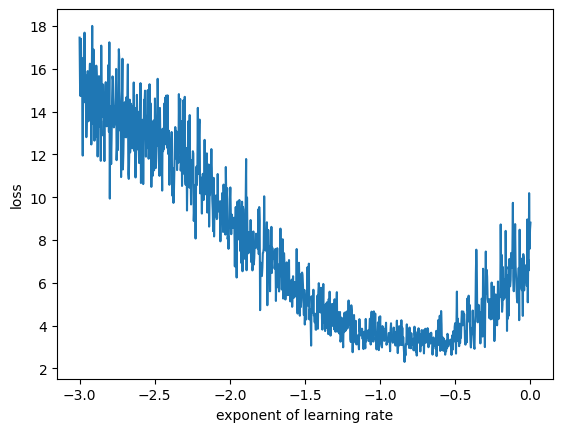

In [36]:
plt.plot(lri, lossi)
# in the beginning, very low learning rate, barely anything happened
# then you get to a nice spot
# then it loss slowly becomes unstable
plt.xlabel("exponent of learning rate")
plt.ylabel("loss")
# looks like the learning rate is pretty good between -1.0 and -0.5
# and past -0.5 it starts to explode
# so -1 is a good learning rate!
# with that exploration, you can just set the learnign rate to 0.1

# so now that we are confident in our learning rates, we can crank up the iterations 

In [37]:
# so init params again
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27, 2), generator=g)
W1 = torch.randn((6,100))
b1 = torch.randn(100)
W2 = torch.randn((100, 27))
b2 = torch.randn(27)
parameters = [C, W1, b1, W2, b2]
print("number of parameters in total", sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

number of parameters in total 3481


In [38]:
# so run the optimization for 1000 steps
for i in range(10000):

    # min-batch construct
    ix = torch.randint(0, X.shape[0], (32,))  # indexes we want to optimize in this iteration

    # forward pass
    emb = C[X[ix]]  # (32, 3, 2)
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1)  # (32, 100)
    logits = h @ W2 + b2  # (32, 27)
    loss = F.cross_entropy(logits, Y[ix])
    #print(f'iteration {iteration}: {loss.item()=}')

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1
    for p in parameters:
        p.data += -lr * p.grad

# let's get loss for whole dataset to get a full sense for how the model is doing now
emb = C[X]
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)  # (228146, 100)
logits = h @ W2 + b2  # (228146, 27)
loss = F.cross_entropy(logits, Y) 
print(f'{loss.item()=}')

loss.item()=2.5174028873443604


# LEARNING RATE DECAY
- at late stages of training, when the loss is starting to plateau, do a LEARNING RATE DECAY
- aka decrease the learning rate 0.1 to 0.001, try this in previous block

# STEPS
1. you first find a decent learning rate
2. then train with that learning rate for some time
3. then do a learning rate decay at late stage

# notes
- so is this a better model than the bigram model? just look at the loss
- well, it depends ont the complexity of the neural net, the bigger it is, your loss may go as low as 0, but what is actually is doing is overfitting
- overfitting meaning it has memorized your data very well but won't give any new type of output
- try the same model on a different testing dataset and the loss may be really high
- then it's not a good model

# SPLIT DATASET INTO TRAINING, DEV/VALIDATION, TEST
- in practice, we split our training set into:
- training, dev/validation, and test datasets
- 80%, 10%, 10% respectively
- the training set is used to optimize the parameters of the model
- the dev/validation set is used to optimize the hyperparameters and settings of the model. like size of hidden layer, strength of regularization, you can try different variations
- the test set is used to evaluate the performance of the model at the end, this is done very few times, otherwise you risk overfitting on the model

In [40]:
# build the dataset
X, Y = build_dataset(3, words)

import random
random.seed(42)
random.shuffle(words)
num_words = len(words)
n1 = int(0.8*num_words)
n2 = int(0.9*num_words)
print(f'{num_words=}, {n1=}, {n2=}, {n2-n1=}, {len(words)-n2=}')
# this will relate to:
# - 25626 training words
# - 3203 dev words
# - 3204 test words
Xtr, Ytr = build_dataset(3, words[:n1])
Xdev, Ydev = build_dataset(3, words[n1:n2])
Xte, Yte = build_dataset(3, words[n2:])
# shapes show number of examples (not number of words)
print(f'{Xtr.shape=}, {Xdev.shape=}, {Xte.shape=}')
print(f'{Ytr.shape=}, {Ydev.shape=}, {Yte.shape=}')


num_words=32033, n1=25626, n2=28829, n2-n1=3203, len(words)-n2=3204
Xtr.shape=torch.Size([182625, 3]), Xdev.shape=torch.Size([22655, 3]), Xte.shape=torch.Size([22866, 3])
Ytr.shape=torch.Size([182625]), Ydev.shape=torch.Size([22655]), Yte.shape=torch.Size([22866])


In [42]:
# so init params again
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27, 2), generator=g)
W1 = torch.randn((6,100))
b1 = torch.randn(100)
W2 = torch.randn((100, 27))
b2 = torch.randn(27)
parameters = [C, W1, b1, W2, b2]
print("number of parameters in total", sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

number of parameters in total 3481


In [43]:
# TRAIN ON TRAINING SET
for i in range(10000):

    # min-batch construct
    ix = torch.randint(0, Xtr.shape[0], (32,))  # indexes we want to optimize in this iteration

    # forward pass
    emb = C[Xtr[ix]]  # (32, 3, 2)
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1)  # (32, 100)
    logits = h @ W2 + b2  # (32, 27)
    loss = F.cross_entropy(logits, Ytr[ix])
    #print(f'iteration {iteration}: {loss.item()=}')

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.01
    for p in parameters:
        p.data += -lr * p.grad

print("loss on batch of training set - ", loss.item())

loss on batch of training set -  2.4479169845581055


In [44]:
# EVALUATE ON TRAINING SET
emb = C[Xtr]
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ytr) 
print(f'loss on whole training set - {loss.item()=}')

loss on whole training set - loss.item()=2.661118984222412


In [45]:
# EVALUATE ON DEV SET
emb = C[Xdev]
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ydev) 
print(f'loss on dev set - {loss.item()=}')

loss on dev set - loss.item()=2.650520086288452


In [46]:
# if loss_train and loss_dev are about the same
# then we are UNDERFITTING
# that means our network is very tiny
# to imporve performance, we need to increase the size of the neural net

# also note that the bigger the network, the longer it may take to converge

In [47]:
# so init params again, let's have 300 parameters output the first layer instead of 100
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27, 2), generator=g)
W1 = torch.randn((6,300))
b1 = torch.randn(300)
W2 = torch.randn((300, 27))
b2 = torch.randn(27)
parameters = [C, W1, b1, W2, b2]
print("number of parameters in total", sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

number of parameters in total 10281


In [ ]:
# now run the optimization for 30000 steps
lossi = []
stepi = []
for i in range(30000):

    # min-batch construct
    ix = torch.randint(0, Xtr.shape[0], (32,))  # indexes we want to optimize in this iteration

    # forward pass
    emb = C[Xtr[ix]]  # (32, 3, 2)
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1)  # (32, 100)
    logits = h @ W2 + b2  # (32, 27)
    loss = F.cross_entropy(logits, Ytr[ix])
    #print(f'iteration {iteration}: {loss.item()=}')

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.05
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    stepi.append(i)
    lossi.append(loss.item())

Text(0, 0.5, 'batch loss')

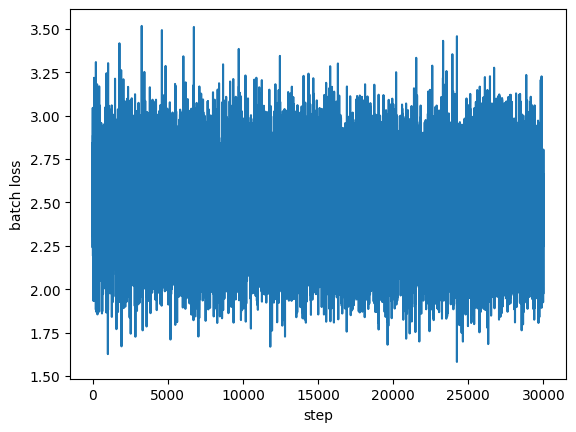

In [50]:
plt.plot(stepi, lossi)
plt.xlabel('step')
plt.ylabel('batch loss')
# the thickness in the plot is due to the fact 
# that we are optimizing on batches of the training set
# this will create a little bit of noise

# another possibility is that the batch size is so small that
# we may want to increase the batch size to get a more correct gradient
# and we can optimize more properly

# even though we made the tanh layer bigger, it could be that the first layer is the bottleneck
# maybe we are cramming way too many dimensions into 2 dimensions 

In [51]:
# EVALUATE ON TRAINING SET
emb = C[Xtr]
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ytr) 
print(f'loss on whole training set - {loss.item()=}')

# EVALUATE ON DEV SET
emb = C[Xdev]
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ydev) 
print(f'loss on dev set - {loss.item()=}')

loss on whole training set - loss.item()=2.4245734214782715
loss on dev set - loss.item()=2.425123929977417


C.shape=torch.Size([27, 2])
C=tensor([[ 0.6046, -0.0146],
        [ 0.1371, -0.4101],
        [ 0.1704, -0.0061],
        [ 0.0675,  0.6235],
        [ 0.0727,  0.0244],
        [-0.3234,  0.6226],
        [ 0.1749,  0.0643],
        [ 0.4702,  1.3685],
        [ 0.1834, -0.0453],
        [-0.1887, -0.3580],
        [ 0.1503,  0.2178],
        [-0.0055,  0.4480],
        [-0.0897,  0.1871],
        [ 0.1852,  0.1780],
        [-0.3506,  0.0504],
        [-0.3868,  0.5850],
        [ 0.0601,  0.6399],
        [-0.0232,  0.0340],
        [-0.1932,  0.2454],
        [ 0.0506, -0.0664],
        [-0.0123, -0.0601],
        [-0.3184,  0.5426],
        [ 0.1234,  0.1541],
        [ 0.1391,  0.0797],
        [-0.1203, -0.0574],
        [-0.5331,  0.3829],
        [ 0.1192,  0.1176]], requires_grad=True)


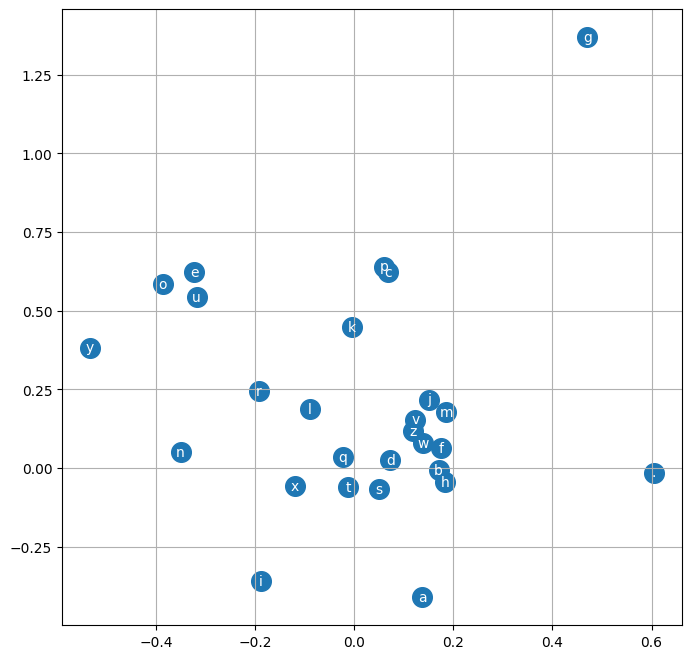

In [52]:
# let's visualize the embeddings that were trained in the neural net
# remember that we have 2 dimensions for all the characters now
print(f'{C.shape=}')
print(f'{C=}')
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):  # numbers 0 - 26
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color="white")
plt.grid("minor")
# x and y coordinates are embedding locations

In [53]:
# so init params again, let's set 10 dimensions for the embeddings
# recall that...
# Xtr.shape=torch.Size([182580, 3]), Xdev.shape=torch.Size([22740, 3]), Xte.shape=torch.Size([22826, 3])
# Ytr.shape=torch.Size([182580]), Ydev.shape=torch.Size([22740]), Yte.shape=torch.Size([22826])

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27, 10), generator=g)  # 10 dimensional embeddings
# C[Xtr] (182580, 3, 10)
W1 = torch.randn((30,200))  # 3*10 input
b1 = torch.randn(200)
W2 = torch.randn((200, 27))
b2 = torch.randn(27)
parameters = [C, W1, b1, W2, b2]
print("number of parameters in total", sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True
print(f'{C.shape}, {Xtr.shape}, {C[Xtr].shape}')

number of parameters in total 11897
torch.Size([27, 10]), torch.Size([182625, 3]), torch.Size([182625, 3, 10])


loss on whole training set - loss.item()=2.3388173580169678
loss on dev set - loss.item()=2.358285903930664


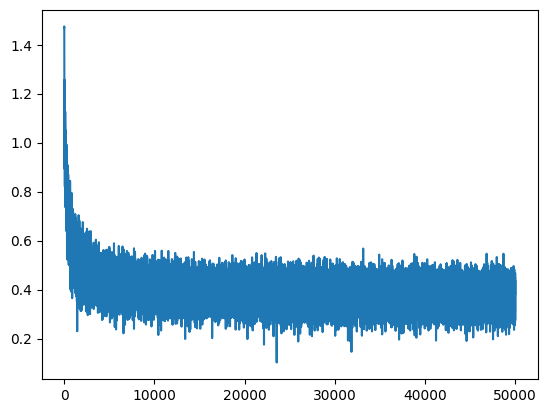

In [54]:
lossi = []
stepi = []

for i in range(50000):

    # min-batch construct
    ix = torch.randint(0, Xtr.shape[0], (32,))  # indexes we want to optimize in this iteration

    # forward pass
    emb = C[Xtr[ix]]  # (32, 3, 2)
    h = torch.tanh(emb.view(-1, 30) @ W1 + b1)  # (32, 100)
    logits = h @ W2 + b2  # (32, 27)
    loss = F.cross_entropy(logits, Ytr[ix])
    #print(f'iteration {iteration}: {loss.item()=}')

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    stepi.append(i)
    lossi.append(loss.log10().item())

plt.plot(stepi, lossi)
plt.xlabel("loss")
plt.ylabel("step")
plt.title("training")

# EVALUATE ON TRAINING SET
emb = C[Xtr]
h = torch.tanh(emb.view(-1, 30) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ytr) 
print(f'loss on whole training set - {loss.item()=}')

# EVALUATE ON DEV SET
emb = C[Xdev]
h = torch.tanh(emb.view(-1, 30) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ydev) 
print(f'loss on dev set - {loss.item()=}')

In [ ]:
# see how training and dev loss are slowly diverging
# that means model is slighlty overfitting

# one you are done changing up your hyperparameters and happy with dev loss
# then you will evaluate the test dataset, and that's the number that matters

In [ ]:
# try beating a dev loss of 2.1701
# you can change the number of neurons in the hidden layer
# you can change the embedding dimension
# you can change the number of characters feeding into context, aka the block size
# you can change details of optimization...
# how long are we running
# the learning rate over time
# how the learning rate decays over time
# the batch size
# check improvement ideas here: # https://www.jmlr.org/papers/volume3/bengio03a/bengio03a.pdf  

In [55]:
# how to sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)
block_size = 3
for _ in range(20):
    out = []
    context = [0] * block_size # init with all ...
    while True:
        emb = C[torch.tensor([context])]  # (1, block_size,d)
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break
    print(''.join(itos[i] for i in out))

carpaifa.
jahmvi.
kimiri.
tatyahnah.
saenmarutafaresanci.
aqui.
jeannia.
chaiim.
janein.
sham.
jori.
quinn.
salin.
alva.
baya.
jeanniearixia.
kaenninu.
toe.
dea.
iatatalley.
